## Yelp photo Classification with Transfer Learning.

Note that the train, test and the valid dataset contains 5 classes: food, menu, outside, interior and drink. Here the train folder has 6000 images, the validation and test folder has 1000 images respectively. In this notebook we will use transfer learning to classify objects in the yelp dataset.

In [1]:
# General Libs
import tensorflow as tf
import glob
import seaborn as sns
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import numpy as np
from pathlib import Path
import random
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
train_path = '/content/drive/MyDrive/Datasets/train_dir'
test_path = '/content/drive/MyDrive/Datasets/test_dir'
valid_path = '/content/drive/MyDrive/Datasets/valid_dir'

In [3]:
train_folder = Path('/content/drive/MyDrive/Datasets/train_dir')
test_folder = Path(f'/content/drive/MyDrive/Datasets/test_dir')
valid_folder = Path('/content/drive/MyDrive/Datasets/valid_dir')

In [4]:
# Choose the hyperparameters
train_size = 6000
valid_size = 1000
test_size = 1000
img_height = 224
img_width = 224
n_classes = 5
batch_size = 32
n_epochs = 20

### Transfer Learning with VGG19

In [5]:
# Initiate the Data generator for VGG19
datagen = ImageDataGenerator(rescale=1.0 / 255, preprocessing_function=preprocess_input)

# Create batches of data from each set (train, test, validation)
train_ds = datagen.flow_from_directory(directory=train_folder,
                                               target_size=(img_height,
                                                            img_width),
                                               color_mode='rgb',
                                               class_mode='categorical',
                                               batch_size=batch_size,
                                               shuffle=True)

valid_ds = datagen.flow_from_directory(directory=valid_folder,
                                               target_size=(img_height,
                                                            img_width),
                                               color_mode='rgb',
                                               class_mode='categorical',
                                               batch_size=batch_size,
                                               shuffle=False)

test_ds = datagen.flow_from_directory(directory=test_folder,
                                              target_size=(img_height,
                                                           img_width),
                                              color_mode='rgb',
                                              class_mode='categorical',
                                              batch_size=batch_size,
                                              shuffle=False)

Found 6000 images belonging to 5 classes.
Found 1000 images belonging to 5 classes.
Found 1000 images belonging to 5 classes.


Check the label dictionary for the test dataset

In [6]:
print('Number of samples: ',test_ds.samples)
print('Number of classes: ',len(test_ds.class_indices))
print('Number of samples per class:', int(test_ds.samples/len(test_ds.class_indices)))

Number of samples:  1000
Number of classes:  5
Number of samples per class: 200


In [7]:
labels = {value: key for key, value in test_ds.class_indices.items()}

print("Label Mappings for classes present in the test dataset\n")
for key, value in labels.items():
    print(f"{key} : {value}")

Label Mappings for classes present in the test dataset

0 : drink
1 : food
2 : interior
3 : menu
4 : outside


Let's plot some images from the test generator

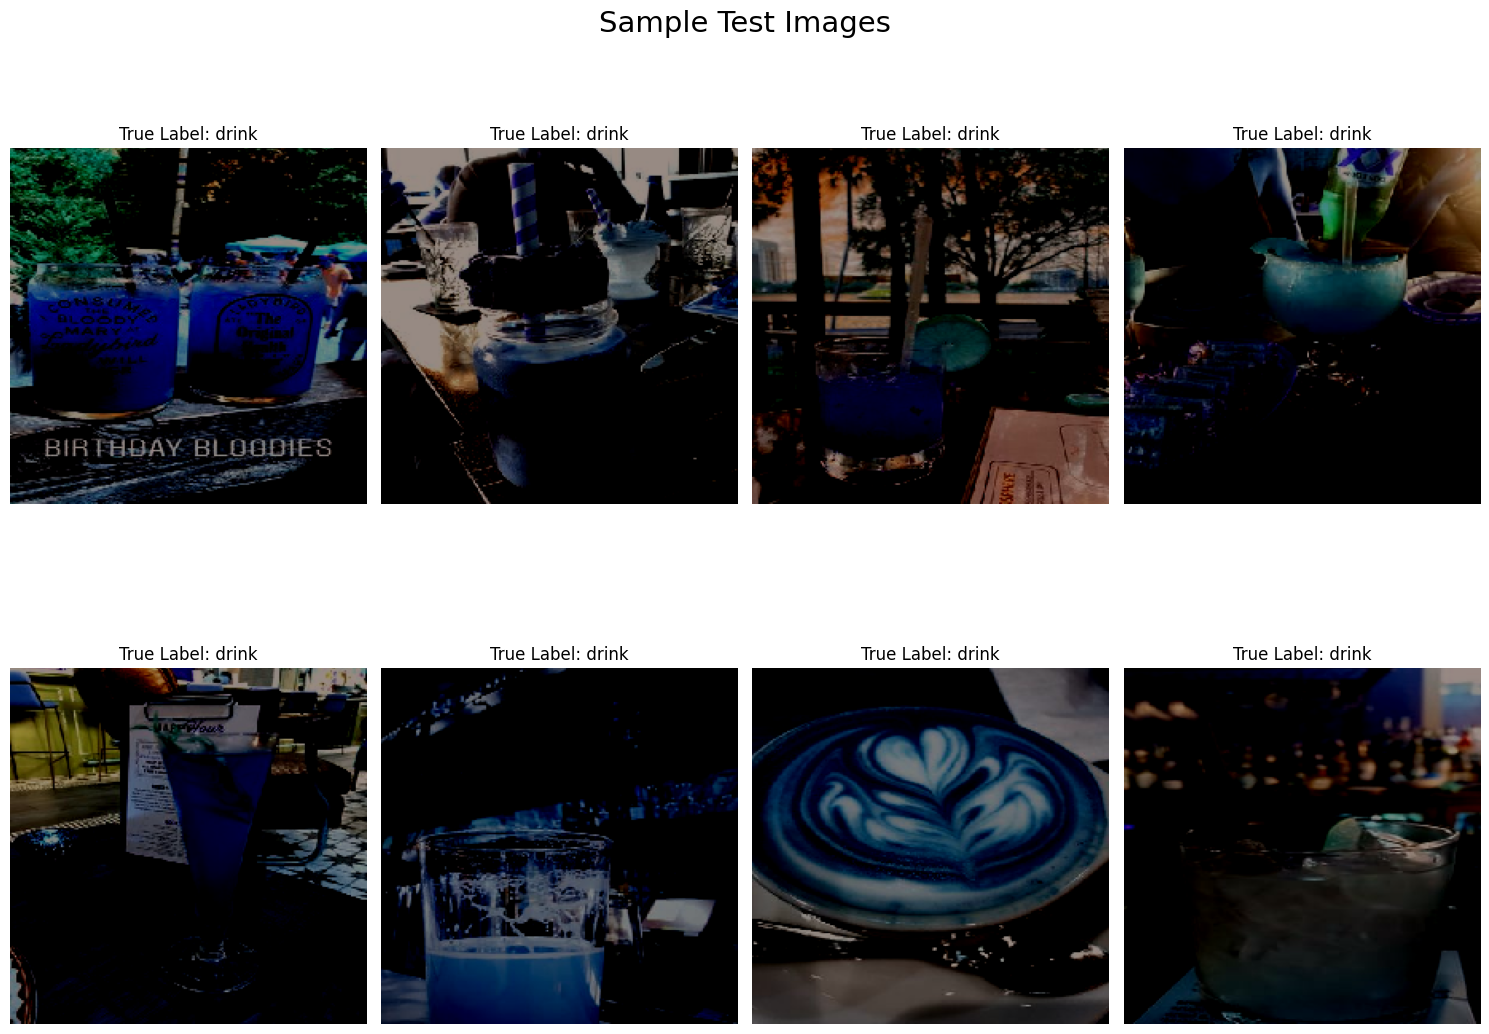

In [8]:
fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(15, 12))
idx = 0

for i in range(2):
    for j in range(4):
        label = labels[np.argmax(test_ds[0][1][idx])]
        ax[i, j].set_title(f"True Label: {label}")
        ax[i, j].imshow(test_ds[0][0][idx][:, :, :])
        ax[i, j].axis("off")
        idx += 1

plt.tight_layout()
plt.suptitle("Sample Test Images", fontsize=21)
plt.show()

### Load the VGG19 Model

We are going to use the VGG19 as a transfer learning framework, we will use the pre-trained ImageNet weights with this model.

In [9]:
#Import the pretrained VGG19 model
vgg_model = VGG19(weights='imagenet', include_top=False, input_shape=(224,224,3))

In [10]:
x = Flatten()(vgg_model.output)
x=Dropout(0.3)(x)
x = Dense(100, activation='relu')(x)
x=Dropout(0.2)(x)
# final softmax layer with 5 categories
predictions = Dense(5, activation='softmax')(x)

# creating the full model:
full_model = Model(inputs=vgg_model.input, outputs=predictions)

In [11]:
# Freezing Convolutional layers
for layer in vgg_model.layers:
    layer.trainable = False

# Summarizing layers
full_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv4 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv4 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv4 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 22,533,789 (85.96 MB)

 Trainable params: 2,509,405 (9.57 MB)

 Non-trainable params: 20,024,384 (76.39 MB)

In [12]:
opt = keras.optimizers.Adam(learning_rate=1e-5)
full_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [13]:
from tensorflow.keras.callbacks import EarlyStopping

es=EarlyStopping(monitor='val_loss',mode='min',verbose=1,patience=5)

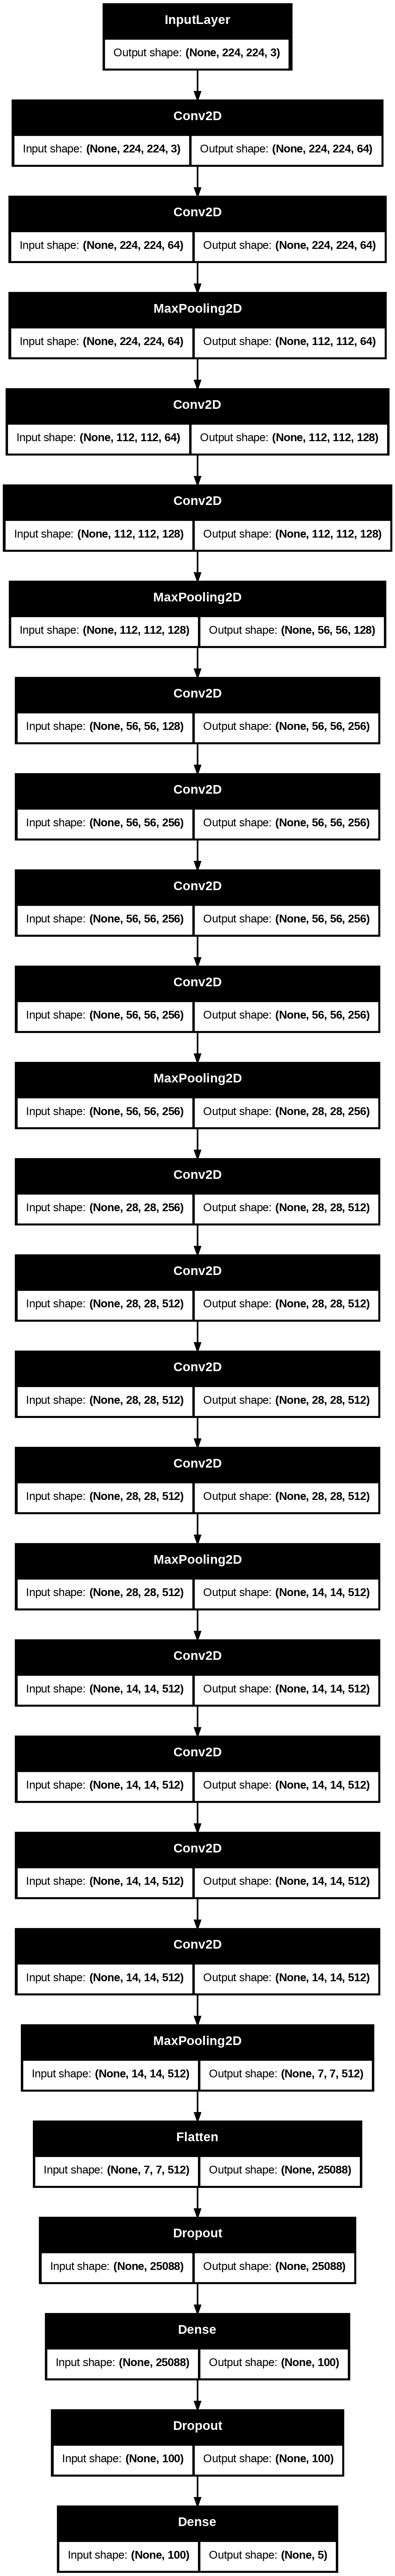

In [14]:
dot_img_file = 'model_1.png'
tf.keras.utils.plot_model(full_model, to_file=dot_img_file, show_shapes=True)

In [15]:
history = full_model.fit(train_ds,epochs=n_epochs,
                               validation_data=valid_ds,
                               steps_per_epoch=train_size // batch_size,
                               validation_steps=valid_size // batch_size,
                               callbacks=[es])

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


187/187 ━━━━━━━━━━━━━━━━━━━━ 87s 367ms/step - accuracy: 0.4216 - loss: 1.3952 - val_accuracy: 0.7692 - val_loss: 0.6557
Epoch 2/20
  1/187 ━━━━━━━━━━━━━━━━━━━━ 30s 164ms/step - accuracy: 0.5625 - loss: 1.1190

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


187/187 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - accuracy: 0.5625 - loss: 1.1190 - val_accuracy: 0.8750 - val_loss: 0.6896
Epoch 3/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 106s 287ms/step - accuracy: 0.7131 - loss: 0.7169 - val_accuracy: 0.8034 - val_loss: 0.5444
Epoch 4/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 481us/step - accuracy: 0.6875 - loss: 0.4919 - val_accuracy: 1.0000 - val_loss: 0.4878
Epoch 5/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 54s 282ms/step - accuracy: 0.7732 - loss: 0.5892 - val_accuracy: 0.8216 - val_loss: 0.4966
Epoch 6/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.8750 - loss: 0.4852 - val_accuracy: 1.0000 - val_loss: 0.4118
Epoch 7/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 80s 286ms/step - accuracy: 0.7921 - loss: 0.5227 - val_accuracy: 0.8246 - val_loss: 0.4685
Epoch 8/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 436us/step - accuracy: 0.9062 - loss: 0.2914 - val_accuracy: 0.8750 - val_loss: 0.4085
Epoch 9/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 81s 281ms/step - accuracy: 0.8111 - loss: 0.4916 - val_accu

In [16]:
from tensorflow.keras.models import load_model

full_model.save('/content/drive/MyDrive/Datasets/Models/VGG19.h5')

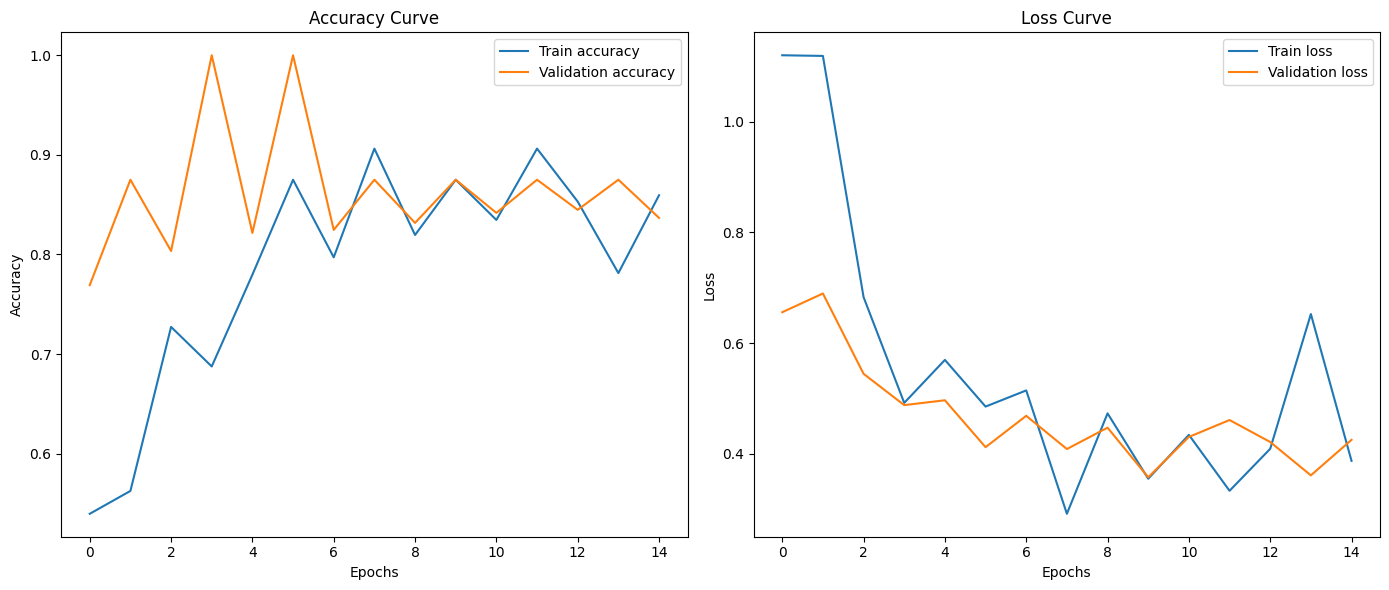

In [17]:
# Create a figure and a grid of subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))  # 1 row, 2 columns

# Plot accuracy
axes[0].plot(history.history['accuracy'], label='Train accuracy')
axes[0].plot(history.history['val_accuracy'], label='Validation accuracy')
axes[0].set_title('Accuracy Curve')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Accuracy')
axes[0].legend()

# Plot loss
axes[1].plot(history.history['loss'], label='Train loss')
axes[1].plot(history.history['val_loss'], label='Validation loss')
axes[1].set_title('Loss Curve')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Loss')
axes[1].legend()

# Adjust layout
plt.tight_layout()
plt.show()

In [18]:
test_loss, test_accuracy = full_model.evaluate(test_ds)

32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 248ms/step - accuracy: 0.8520 - loss: 0.4013


In [19]:
print(f"Test Loss:     {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

Test Loss:     0.4121566116809845
Test Accuracy: 0.8429999947547913


In [20]:
model = load_model('/content/drive/MyDrive/Datasets/Models/VGG19.h5')

In [21]:
preds = model.predict(test_ds, batch_size=batch_size)

y_pred=np.argmax(preds,axis=1)
y_true = test_ds.classes

32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 200ms/step


In [22]:
from sklearn.metrics import confusion_matrix

# Create confusion matrix
cm = confusion_matrix(test_ds.classes, y_pred)

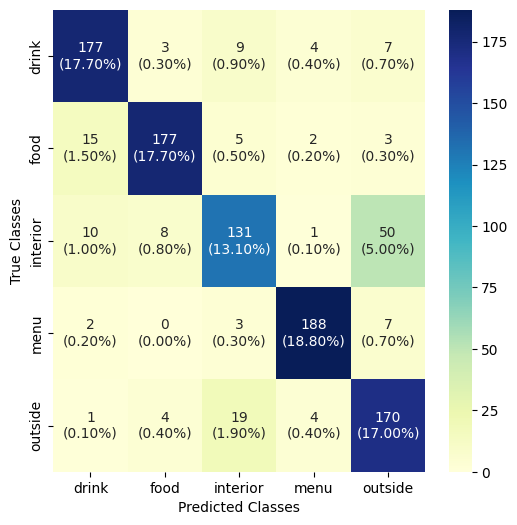

In [23]:
group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cm.flatten()/np.sum(cm)]
box_labels = [f"{v1}\n({v2})" for v1, v2 in zip(group_counts, group_percentages)]
box_labels = np.asarray(box_labels).reshape(5, 5)

plt.figure(figsize = (6, 6))
sns.heatmap(cm, xticklabels=labels.values(), yticklabels=labels.values(),
           cmap="YlGnBu", fmt="", annot=box_labels)
plt.xlabel('Predicted Classes')
plt.ylabel('True Classes')
plt.show()

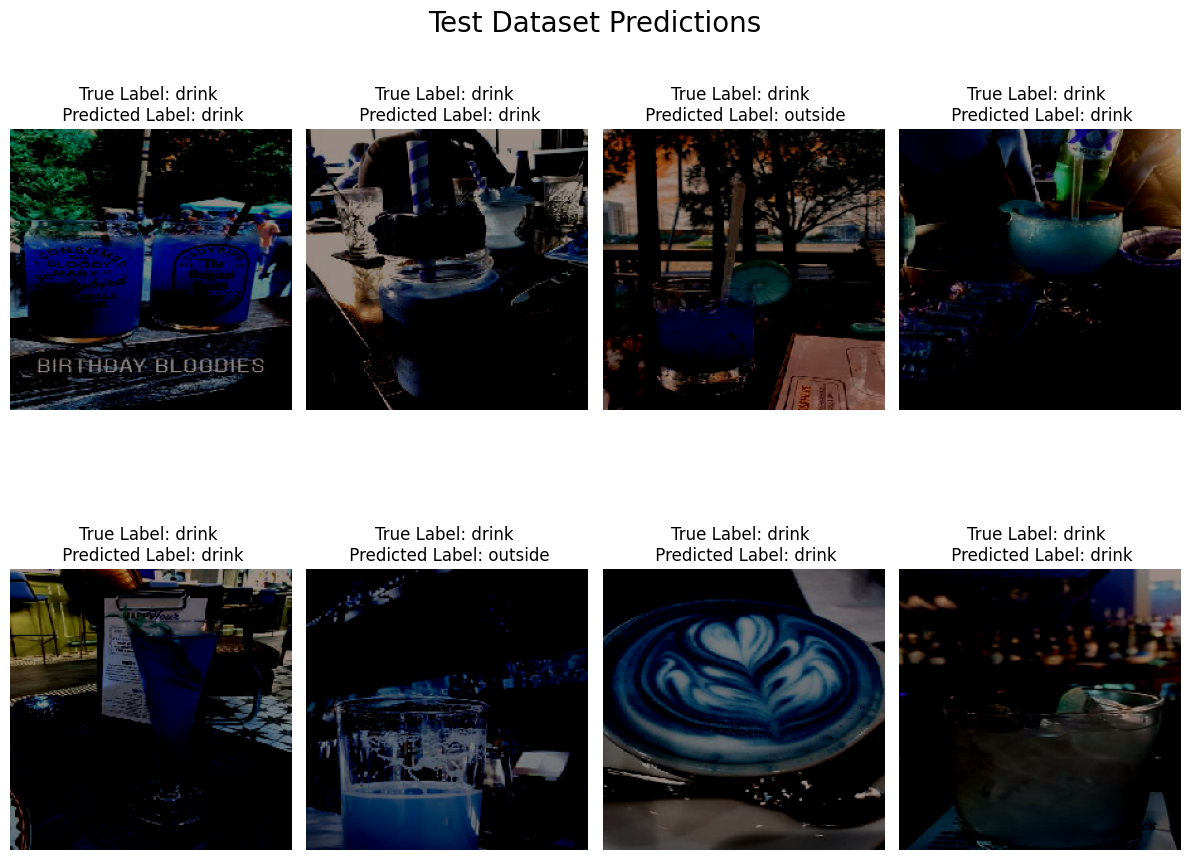

In [24]:
fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(12, 10))
idx = 0

for i in range(2):
    for j in range(4):
        predicted_label = labels[np.argmax(preds[idx])]
        ax[i, j].set_title(f"True Label: {label} \n Predicted Label: {predicted_label}")
        ax[i, j].imshow(test_ds[0][0][idx])
        ax[i, j].axis("off")
        idx += 1

plt.tight_layout()
plt.suptitle("Test Dataset Predictions", fontsize=20)
plt.show()